In [108]:
import numpy as np
import pandas as pd
import pandana as pdna
import geopandas as gp
import matplotlib.pyplot as plt
%matplotlib inline
# import folium

In [113]:
# def compare(table, column):
#     return len(table[column].unique())

In [109]:
homedata_file_path = '/home/data/'
dd = '/home/data/spring_2019/base/'
shapefiles_path = '/home/simon/spatial-data/'
model_outputs_path = '/home/data/spring_2019/outputs/'

In [110]:
def get_data():
    '''gets all relevant tables from the HDF5 and saves them to a dictionary that is indexed by 1) year and 
    2) table name. Closes the store. The function is assigned to the global variable data_dict'''
    
    hdfstore = pd.HDFStore(model_outputs_path+'model_data_output.h5', mode='r') #sometimes doesnt work with a relative file path
    for year in [2010, 2015, 2025]:
        persons = hdfstore["/{}/persons".format(year)]
        hh = hdfstore["/{}/households".format(year)]
        buildings = hdfstore["/{}/buildings".format(year)]
        parcels = hdfstore["/{}/parcels".format(year)]
        jobs = hdfstore["/{}/jobs".format(year)]
        data_dict[year] = {"hh": hh, "buildings": buildings, "parcels": parcels, "jobs": jobs, "persons": persons}
#         data_dict.update({year: {"hh": hh, "buildings": buildings, "parcels": parcels, "jobs": jobs}})
    print("closing store")
    hdfstore.close()
    return data_dict

data_dict = get_data()
    

closing store


In [172]:
def get_merged_data(year):
    '''merges the household and buildings and parcels and persons tables together in an inner merge, 
    resulting in a dataframe with every person, their household information and their geographic information
    like block group id and parcel id, and node id'''
        
    print("merging buildings to parcels")
    buildings = data_dict[year]["buildings"].reset_index()[["building_id", "parcel_id"]]
    parcels = data_dict[year]["parcels"].reset_index()[["parcel_id", "county_id", "node_id"]]
    bldg_parc = pd.merge(buildings, parcels, on="parcel_id")
    hh = data_dict[year]["hh"]
    persons = data_dict[year]["persons"]
    print("merging households to buildings and parcels table")
    
    hh_build = pd.merge(hh, bldg_parc, on="building_id")
    
    print("merging households to buildings")

    hh_build.index.name = "household_id"
    
    hh_build = hh_build.reset_index()
    
    

    print("merging persons to households and buildings")
    persons = data_dict[year]["persons"]
    persons.index.name = "person_id"
    
    buildings_persons = pd.merge(persons, hh_build, on='household_id')
    print("hh build table has ", len(hh_build), "rows")
    
    buildings_persons["block_group_id"] = buildings_persons["block_group_id"].apply(lambda x: "0"+x)
    buildings_persons["census_tract"] = buildings_persons["block_group_id"].apply(lambda x: x[:-1])
    return buildings_persons

In [160]:
def get_job_locations(year):
    '''get the location of the jobs by merging the jobs table with the buildings table on building_id and that
    table with the parcels table on parcel_id, resulting in each job being assigned to a node id to be used
    in the pandana network'''
    
    buildings = data_dict[year]['buildings'].reset_index()
    jobs = data_dict[year]['jobs'].reset_index()
    parcels = data_dict[year]['parcels'].reset_index()
    
    print("merging buildings to jobs")
    jobs_buildings = pd.merge(buildings, jobs, on='building_id')
    
    print("merging buildings with jobs to parcels")
    jobs_merge = pd.merge(jobs_buildings, parcels, on='parcel_id')
    return jobs_merge

In [114]:
def get_workers_by_race(year):
    '''Get the number of workers for each race by node, for a given year. Returns a dataframe
    with a column for each race and the number of workers assigned to that node by race. The node assignments
    are obtained from the person-> parcel match in get_merged_data()'''
    
    node_df_lol = []
    node_id_list = []
    df = get_merged_data(year)
    for node_id, node_df in df.groupby("node_id"):
        nhwhite_workers = sum((node_df["race_id"] == 1) & (node_df["hispanic"] == 1) & (node_df["worker"] == 1))
        nhblack_workers = sum((node_df["race_id"] == 2) & (node_df["hispanic"] == 1) & (node_df["worker"] == 1))
        nhasian_workers = sum((node_df["race_id"] == 6) & (node_df["hispanic"] == 1) & (node_df["worker"] == 1))
        hispanic_workers = sum((node_df["hispanic"] != 1) & (node_df["worker"] == 1))
        non_workers_any = sum(node_df["worker"] == 0)
        block = node_df['block_group_id'].iloc[0] # i think this is ok for now because they should all be the same
        node_id_list.append(node_id)

        row = [nhwhite_workers, nhblack_workers, nhasian_workers, hispanic_workers, non_workers_any, block]
        node_df_lol.append(row)
        
    workers_by_node = pd.DataFrame(node_df_lol, columns=["nhwhite_workers", "nhblack_workers","nhasian_workers",
            "hispanic_workers", "non_workers_any", "block_group"], index=node_id_list)
    
    
    return workers_by_node

Pandana Accessibility Calcs

In [121]:
# beam_network_links = pd.read_csv('beam-network-links.csv')
# beam_network_nodes = pd.read_csv('beam-network-nodes.csv')

In [125]:
# net=pdna.Network(beam_network_nodes.x, beam_network_nodes.y, beam_network_links["from"], beam_network_links["to"],
#                  beam_network_links[["travelTime"]])
# net.precompute(10000)



/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/pandana/network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


In [153]:
def get_job_accessibilities(net, year, dist):
    '''returns the number of jobs within a radius of dist of each node'''
    df = get_jobs(year)
    workers_df = get_workers_by_race(get_merged_data(year))
    node_ids = df["node_id"]
    n = net.set(node_ids)
    %time s = net.aggregate(dist, type="sum", decay="linear")
    access = pd.DataFrame(s)
    access = access.rename({0:"jobs"}, inplace=False, axis=1)
    access = pd.merge(workers_df, access, right_index=True, left_index=True)
    return access
        

In [157]:
#an intermediate step to save data just in case
get_job_accessibilities(net, 2025, 10000).to_csv('indicators_output/accessibilities_2025_1000.csv', index=False)
get_job_accessibilities(net, 2015, 10000).to_csv('indicators_output/accessibilities_2015_1000.csv', index=False)
get_job_accessibilities(net, 2010, 10000).to_csv('indicators_output/accessibilities_2010_1000.csv', index=False)


,nhwhite_workers,nhblack_workers,nhasian_workers,hispanic_workers,non_workers_any,block_group,jobs
8,0,0,4,0,0,60855126021,617536.0000
55,0,0,0,0,2,60855103001,771869.9375
56,3,0,0,0,2,60855104003,769705.6250
57,5,0,0,0,2,60855104003,764429.5625
58,4,0,0,0,4,60855104003,764947.4375
60,9,1,0,2,10,60855065013,734209.9375
61,1,0,0,0,4,60855104002,734192.1875
62,2,0,0,0,5,60855105003,733720.8750
63,1,0,0,0,3,60855104002,745316.7500
64,0,0,0,0,4,60855104001,745405.2500


$$\text{weighted accessibility} = E[\text{# of accessible jobs}|\text{race R}] =$$

$$\sum_{i=1}^n P(\text{person of race R and person assigned to node}_i) \times \text{# jobs assigned to node}_i =$$

$$\sum_{i=1}^n P(\text{person of race R | person assigned to node}_i) \times P(\text{person assigned to node}_i) \times \text{# jobs assigned to node}_i =$$

$$\sum_{i=1}^n \frac{\text{# persons of race R assigned to node}_i}{\text{# persons assigned to node}_i} \times \frac{\text{# persons assigned to node}_i}{\text{# of people in blk group}} \times (\text{# of jobs assigned to node}_i) =$$

$$\sum_{i=1}^n \frac{\text{# persons of race R assigned to node}_i}{\text{# of people in blk group}} \times (\text{# of jobs assigned to node}_i)$$

where $i$ is a node in the block group/other geography.

In [226]:
def accessibilities_by_race(year, dist, net, geography): 
    '''This is the the essence of the computation being performed to get the race-based accessibilities. This function
    takes in the year, buffer distance, pandana network (should be precomputed) and desired geography (right now this
    notebook has shapefiles set up for census tract ("census_tract") and block group ("block_group"). Returns a table indexed by 
    the id of the geography, and a column for each weighted accessibility by race.'''
    geo_df_lol = []
    geo_id_list = []
    
    df = get_job_accessibilities(net, year, dist)
    for geo, geo_df in df.groupby(geography):
        people_per_geo = sum(geo_df["nhwhite_workers"] + geo_df["nhblack_workers"]+geo_df["nhasian_workers"]+geo_df["hispanic_workers"])+1e-6
        node_access_nhw = sum(geo_df["nhwhite_workers"]*geo_df["jobs"])/people_per_geo
        node_access_nhb = sum(geo_df["nhblack_workers"]*geo_df["jobs"])/people_per_geo
        node_access_nha = sum(geo_df["nhasian_workers"]*geo_df["jobs"])/people_per_geo
        node_access_h = sum(geo_df["hispanic_workers"]*geo_df["jobs"])/people_per_geo
        geo_id_list.append(geo)
        row = [node_access_nhw, node_access_nhb, node_access_nha, node_access_h]
        geo_df_lol.append(row)
        
    access_geo = pd.DataFrame(geo_df_lol, columns=["access_nhwhite", "access_nhblack","access_nhasian",
              "access_hispanic"], index=geo_id_list)
    
    
    return access_geo



In [118]:
bay_county_codes = ['001', '013', '097', '095', '081', '085', '075', '041', '055'] 


In [139]:
block_groups = gp.read_file(shapefiles_path+'tl_2018_06_bg/tl_2018_06_bg.shp')
bay_bg = block_groups[(block_groups["COUNTYFP"].isin(bay_county_codes)) & (block_groups["ALAND"]> 100)]

tracts = gp.read_file(shapefiles_path+'tl_2018_06_tract/tl_2018_06_tract.shp')
bay_tracts = tracts[(tracts["COUNTYFP"].isin(bay_county_codes)) & (tracts["ALAND"]> 100)]



,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
17,06,013,324002,06013324002,3240.02,Census Tract 3240.02,G5020,S,2019541,0,+37.9514985,-122.0605612,"POLYGON ((-122.073128 37.947932, -122.072757 3..."
18,06,013,320004,06013320004,3200.04,Census Tract 3200.04,G5020,S,7108004,39729,+38.0022389,-122.0762604,"POLYGON ((-122.101872 38.00463, -122.101857 38..."


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
53,06,001,402600,1,060014026001,Block Group 1,G5030,S,318842,0,+37.8042701,-122.2799551,"POLYGON ((-122.283307 37.801744, -122.283262 3..."
57,06,001,402700,1,060014027001,Block Group 1,G5030,S,207667,0,+37.8099582,-122.2756230,"POLYGON ((-122.278594 37.807413, -122.278482 3..."


In [141]:
def merge_geographies(year, dist, net, geography):
    'merge the relevant shapefiles with the race weighted accessibilities tables to allow mapping'
    df = accessibilities_by_race(year, dist, net, geography)
    if (geography == 'census_tract'):
        return pd.merge(bay_tracts, df, right_index=True, left_on='GEOID')
    elif (geography == 'block_group'):
        return pd.merge(bay_bg, df, right_index=True, left_on='GEOID')
    


In [ ]:
##add the final access tables
access_10000_2025_bg = merge_geographies(2025, 10000, net, "block_group").to_csv("indicators_output/access_10000_2025_bg.csv")
access_10000_2015_bg = merge_geographies(2015, 10000, net, "block_group").to_csv("indicators_output/access_10000_2015_bg.csv")
access_10000_2010_bg = merge_geographies(2010, 10000, net, "block_group").to_csv("indicators_output/access_10000_2010_bg.csv")
access_10000_2025_tract = merge_geographies(2025, 10000, net, "census_tract").to_csv("indicators_output/access_10000_2025_tract.csv")
access_10000_2015_tract = merge_geographies(2015, 10000, net, "census_tract").to_csv("indicators_output/access_10000_2015_tract.csv")
access_10000_2010_tract = merge_geographies(2010, 10000, net, "census_tract").to_csv("indicators_output/access_10000_2010_tract.csv")

#### Maps


Text(0.5,1,'hispanic job access 2025')

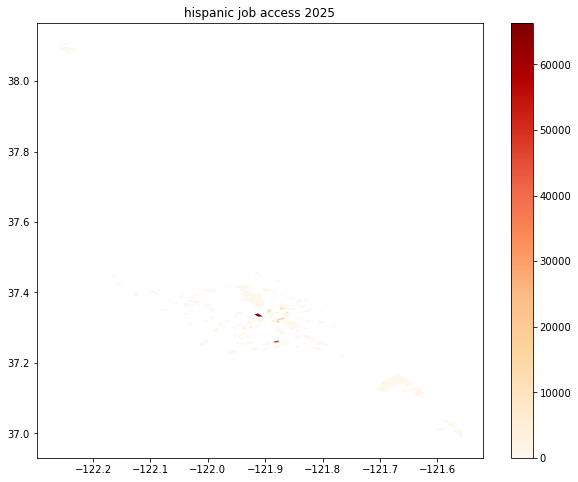

In [252]:
# f, hisp_25 = plt.subplots(1, figsize=(10,8))
# hisp_25 = block_access_shp.plot(ax=hisp_25, column='access_hispanic', legend = True, cmap='OrRd')
# hisp_25.set_title("hispanic job access 2025")
# plt.savefig("bg_his_jobs_10000m_2025")

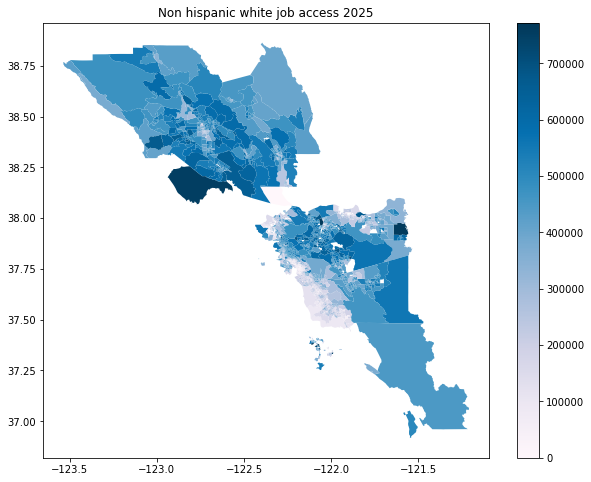

In [54]:
# f, nhw_25 = plt.subplots(1, figsize=(10,8))
# nhw_25 = block_access_shp.plot(axes=nhw_25, column='access_nhwhite', legend = True, cmap='PuBu')
# nhw_25.set_title("Non hispanic white job access 2025")
# plt.savefig("bg_nhw_jobs_10000m_2025")



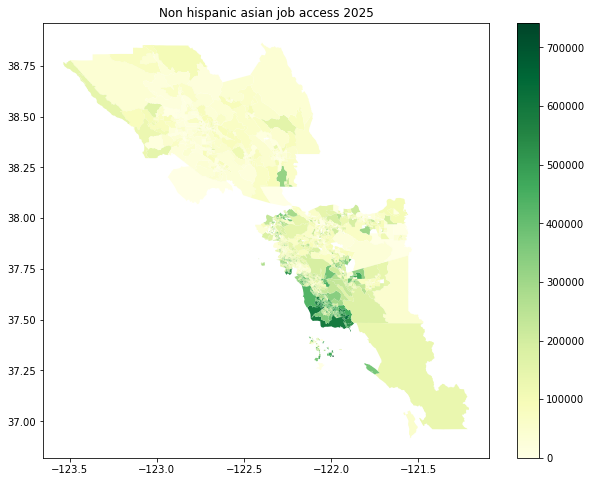

In [55]:
# f, nha_25 = plt.subplots(1, figsize=(10,8))
# nha_25 = block_access_shp.plot(axes=nha_25, column='access_nhasian', legend = True, cmap='YlGn')
# nha_25.set_title("Non hispanic asian job access 2025")
# plt.savefig("bg_nha_jobs_10000m_2025")



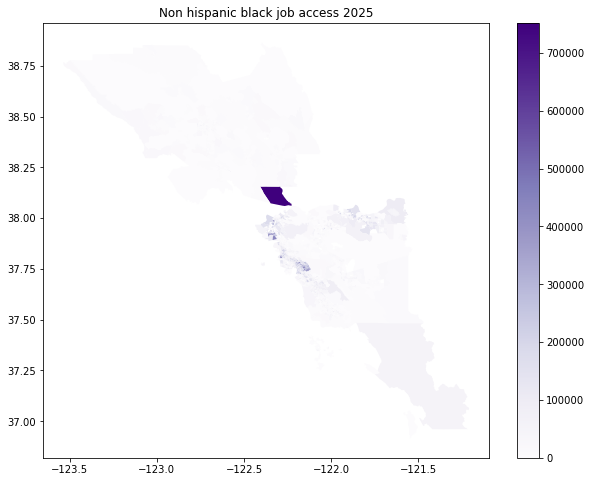

In [58]:
# f, nhb_25 = plt.subplots(1, figsize=(10,8))
# nhb_25 = block_access_shp.plot(ax = nhb_25, column='access_nhblack', legend = True, cmap='Purples')
# nhb_25.set_title("Non hispanic black job access 2025")
# plt.savefig("bg_nhb_jobs_10000m_2025")

